The point of this notebook is to provide a relatively user-friendly interface for finding passages related to a given passage, via comparison of their OpenAI vector embeddings. I presume that the texts have already been loaded into the Tesserae database and vectorized, following the scripts in the Maximus-bioinformatics notebook. 

In [1]:
from bson import ObjectId
import pandas as pd
from tesserae.db import TessMongoConnection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='maximus')

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "index": 1, "tags": {"$arrayElemAt": ["$tags", 0]}, "unit_type": 1, "vector": 1}}],
                                              encode=False))
    vectors['title'] = title
    data = np.array([np.array(vector) for vector in vectors['vector']])
    metadata = vectors.T.drop('vector').T
    return data, metadata

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def find_related(passage,title,unit_type='line',n_components=500,N=15,plot=False):
    if 'phrase' not in passage.keys():
        passage['phrase']=0

    #Load source and target data
    data_s, metadata_s = load_vectors_from_mongodb(passage['title'],unit_type=passage['unit_type'])
    data_t, metadata_t = load_vectors_from_mongodb(title,unit_type=unit_type)
    data = np.vstack((data_s,data_t))

    #Find text id's
    text_s = connection.find('texts',title=passage['title'])[0].id
    text_t = connection.find('texts',title=title)[0].id

    #Reduce to relevant dimensions using PCA
    pca_result = fit_and_transform_pca(data,n_components=n_components)
    pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T
    N_s = len(data_s)
    data_s = pca_result[:N_s]
    data_t = pca_result[N_s:]

    #Find the text of the source passage and its index, then compute distances
    content = connection.find('units',tags=passage['tag'],text=text_s,unit_type=passage['unit_type'])[passage['phrase']]
    idx = metadata_s.loc[metadata_s['index']==content.index].index[0]
    metadata_t['distance'] = data_t.dot(data_s[idx,:])

    #Plot all distances for reference
    if plot:
        plt.hist(metadata_t['distance'],bins=100)
        plt.show()

    print('Source passage:')
    print(content.snippet)
    print('-----------------')
    print('-----------------')

    #Sort by distance and print
    metadata_sorted = metadata_t.sort_values('distance',ascending=False)
    k = 0
    while k <= N:
        idx_k = metadata_sorted['index'].iloc[k]
        tag_k = metadata_sorted['tags'].iloc[k]
        dist_k = metadata_sorted['distance'].iloc[k]
        text_k = connection.find('units',index=idx_k,text=text_t,unit_type=unit_type)[0].snippet
    
        print(str(k)+'. '+title+' '+tag_k+', distance = '+str(dist_k))
        print(text_k)
        print('-----------------')
        k+=1

    return metadata_sorted

In [5]:
title_id = connection.find('texts',title='Mystagogia')[0].id
content = connection.find('units',tags='prol.1',text=title_id,unit_type='phrase')[0]
content.snippet

'Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος.'

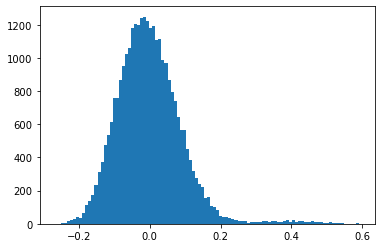

Source passage:
Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος.
-----------------
-----------------
0. Old Testament Pro.17.28, distance = 0.5919312333871828
ἀνοήτῳ ἐπερωτήσαντι σοφίαν σοφία λογισθήσεται, ἐνεὸν δέ τις ἑαυτὸν ποιήσας δόξει φρόνιμος εἶναι.
-----------------
1. Old Testament Pro.13.20, distance = 0.5850904263459417
ὁ συμπορευόμενος σοφοῖς σοφὸς ἔσται, ὁ δὲ συμπορευόμενος ἄφροσι γνωσθήσεται.
-----------------
2. Old Testament Sir.20.27, distance = 0.5771541678836838
Ὁ σοφὸς ἐν λόγοις προάξει ἑαυτόν, καὶ ἄνθρωπος φρόνιμος ἀρέσει μεγιστᾶσιν.
-----------------
3. Old Testament Pro.1.5, distance = 0.5467186250932692
τῶνδε γὰρ ἀκούσας σοφὸς σοφώτερος ἔσται, ὁ δὲ νοήμων κυβέρνησιν κτήσεται
-----------------
4. Old Testament Pro.9.9, distance = 0.5460799785125077
δίδου σοφῷ ἀφορμήν, καὶ σοφώτερος ἔστ

In [6]:
passage = {'title': 'Mystagogia', 'tag': 'prol.1', 'phrase': 0, 'unit_type':'phrase'}
metadata = find_related(passage,'Old Testament',unit_type='line',plot=True)

It seems to work, but it's extremely slow